# Chapter 4 Forward Uncertainty Quantification via Polynomial Chaos Expansion

In [ ]:
using PolyChaos, Plots, QuadGK, DifferentialEquations, LaTeXStrings, KernelDensity, StatsBase, Distributions, ProgressMeter

#### Utilities

In [3]:
"""
Computes moments with the PCE coefficients
https://github.com/timueh/VanDeVusseUnderUncertainty
"""
function getSolution(data::Vector{<:Vector}, op::AbstractOrthoPoly)
    mu = [ PolyChaos.mean(d, op) for d in data ]
    sig = [ PolyChaos.std(d, op) for d in data ]
    mu, sig
end

"""
Computes moments with the PCE coefficients
https://github.com/timueh/VanDeVusseUnderUncertainty
"""
function getSolution(sol, op::AbstractOrthoPoly)
    L = PolyChaos.dim(op)
    nx = 2
    inds = map(i -> (1+(i-1)*L):(i*L), 1:nx)
    xsols = map( ind -> [u[ind] for u in sol.u], inds) 
    moments = map(x -> getSolution(x, op), xsols)
    moments[1][1], moments[1][2], moments[2][1], moments[2][2]
end;

"""
Returns the values and indices of the top K largest/smallest values.
From https://discourse.julialang.org/t/what-is-julias-maxk-matlab-that-returns-the-indice-of-top-k-largest-values/14100
"""
function getIndx(a, k, max=true)
    b = partialsortperm(a, 1:k, rev=max)
    return collect(zip(b, a[b]))
end;

"""
Return KDE estimate and the associated mean μ and standard deviation σ
    Inputs:
        - dist: array of realization of a random variable (e.g. QoI)
    Outputs:
        - kde_: kernel denstiy estimate
        - μ: mean
        - σ: standard deviation
        - skew: skewness
        - kurtosis: kurtosis
"""
function getStatistics(dist)
    kde_ = KernelDensity.kde(dist)
    μ = round(StatsBase.mean(dist),digits=2)
    σ = round(StatsBase.std(dist),digits=2)
    skew = round(StatsBase.skewness(dist),digits=2)
    kurt = round(StatsBase.kurtosis(dist),digits=2)
    kde_, μ, σ, skew, kurt
end;

"""
Return KDE estimate and the associated mean μ and standard deviation σ
    Inputs:
        - coeffs_: coefficients of the multivariate polynomials
        - ξ: measure
        - mop: multivariate polynomials
    Outputs:
        - kde_: kernel denstiy estimate
        - μ: mean
        - σ: standard deviation
        - skew: skewness
        - kurt: kurtosis
"""
function getKDEμσ(coeffs_, ξ, mop)
    dist_ = evaluatePCE(coeffs_, ξ, mop)
    kde_ = KernelDensity.kde(dist_)
    μ = round(StatsBase.mean(dist_),digits=2)
    σ = round(StatsBase.std(dist_),digits=2)
    skew = round(StatsBase.skewness(dist_),digits=2)
    kurt = round(StatsBase.kurtosis(dist_),digits=2)
    kde_, μ,  σ, skew, kurt
end;

"""
Function to determine the array elements within the credible interval

    Inputs:
        - dens: kde-density
        - vals: sampled values

    Outputs: 
        - cred_elements: elements within the credible interval
""" 
function getCredElements(dens,vals)
    # Get the 95% quantiles to construct the credible intervals
    lb_cred = StatsBase.quantile(vals,0.025)
    ub_cred = StatsBase.quantile(vals,0.975)
    # transform univariatekde in 2D array
    kde_dens = hcat(dens.x,dens.density)
    cred_elements = kde_dens[(lb_cred.<=kde_dens[:,1]).&(kde_dens[:,1].<=ub_cred),:]
    cred_elements
end;

# Example 5.1

# Polynomial Chaos Expansion (PCE) with a Galerkin Projection Approach to determine the PCE coefficients

**Lotka-Volterra model**: The model under consideration describes the interaction of predators (e.g. wolves) $y$ and preys (e.g. rabbits) $x$

\begin{align}
\dot{x} = \alpha x -\beta x y\\
\dot{y} = \gamma x y - \delta y
\end{align}

where
- $\alpha$ is the natural growth rate of preys in the absence of predation
- $\beta$ is the death rate per encounter of rabbits due to predation
- $\gamma$ is the efficiency of turning predated preys into predators (reproduction rate of predator per prey)
- $\delta$ is the natural death rate of predators in the absence of food (preys)

In our setting we assume that the initial conditions $x(0) = x_0, y(0) = y_0$ and the parameters $\beta$, $\gamma$ are certain and therefore fixed. We suppose that the uncertain parameters $\alpha$ and $\delta$ are normal distributed, i.e. $Q \sim \mathcal{N}(\mu, \sigma)$.

In [4]:
"""
Deterministic ODE function for a Lotka-Volterra model
"""
function lotkaODEdeterministic!(du,u,p,t)
    α,β,γ,δ = p
    x,y = u[1],u[2]
    
    du[1] = x′ = α*x - β*x*y
    du[2] = y′ = γ*x*y - δ*y
end;

In [5]:
# certain (fixed) parameters for the Lotka-Volterra model
β = 0.5 # death rate per encounter of rabbits due to predation
γ = 0.2 # efficiency of turning predated preys into predators (reproduction rate of predator per prey)

# moments for uncertain gaussian distributed parameters
# natural growth rate of preys in the absence of predation
μ_α = 3.5
σ_α = 0.02*μ_α
# natural death rate of predators in the absence of food (preys)
μ_δ = 4.5
σ_δ = 0.02*μ_δ

0.09

Visualization of the uncertain parameters.

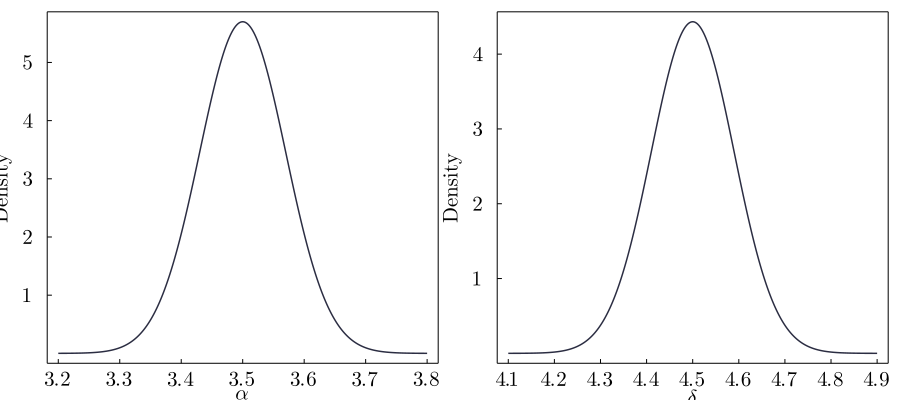

In [6]:
fontsize_tick=14
fontsize_legend=12
fonsize_label = 14
fonsize_titel = 20

x_α = collect(3.2:0.001:3.8)
ρ_α = pdf.(Distributions.Normal(μ_α,σ_α),x_α)
p1 = plot(x_α, ρ_α; framestyle=:box, grid=:none, lw=1.5,label=:none,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"\alpha",
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([3.2,3.3,3.4,3.5,3.6,3.7,3.8],[L"3.2",L"3.3",L"3.4",L"3.5",L"3.6",L"3.7",L"3.8"]),
          yticks = ([1,2,3,4,5],[L"1",L"2", L"3",L"4",L"5"]),)

x_δ = collect(4.1:0.001:4.9)
ρ_δ = pdf.(Distributions.Normal(μ_δ,σ_δ),x_δ)
p2 = plot(x_δ, ρ_δ; framestyle=:box, grid=:none, lw=1.5,label=:none,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"\delta",
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9],[L"4.1",L"4.2",L"4.3",L"4.4",L"4.5",L"4.6",L"4.7",L"4.8",L"4.9"]),
          yticks = ([1,2,3,4,5],[L"1",L"2", L"3",L"4",L"5"]),)
plot(p1,p2; size=(900,400))

In [7]:
# Initial values for the Lotka-Volterra model
x₀ = 10 # preys
y₀ = 10 # predators

u₀ = [x₀,y₀];

# Timespan
tend = 5.
tspan = (0.0,tend)
Δt = 0.01;

## Uncertainty Propagation

It should be noted, that the following section is only a brief overview of the polynomial chaos expansion (PCE), which is not quite correct formally. In our case, we have a multivariate PCE (two uncertain parameters). We refer to 
- [Algorithms for Uncertainty Quantification - Polynomial Chaos Approximation 1](https://www5.in.tum.de/lehre/vorlesungen/algo_uq/ss18/06_polynomial_chaos.pdf)
- [Introduction to Uncertainty Quantification - chap. 11 Spectral Expansions](https://www.springer.com/de/book/9783319233949)
- [Uncertainty Quantification - chap. Stochastic Spectral Methods](https://rsmith.math.ncsu.edu/UQ_TIA/)

for the theory on PCE.
Further, we refer to 
- [Algorithms for Uncertainty Quantification - Polynomial Chaos Approximation 2: The Stochastic
Galerkin Approach](https://www5.in.tum.de/lehre/vorlesungen/algo_uq/ss18/07_galerkin.pdf)
- [Uncertainty Quantification - chap. 10.2](https://rsmith.math.ncsu.edu/UQ_TIA/)
- [Introduction to Uncertainty Quantification - chap. 12 Stochastik Galerkin Methods](https://www.springer.com/de/book/9783319233949)

for the theory on Galerkin projection.

Since our Lotka-Volterra model includes two random parameters $\alpha$ and $\delta$, the solution itself is a time-varying random variable, i.e. $X$ and $Y$. We use polynomial chaos expansion (PCE) to reduce the computational cost of the uncertainty propagation step. In a PCE we try, to decompose a QoI-map $\mathcal{G}(t,Q)$ into a series of products of PCE coefficients and orthogonal polynomials (c.f. Fourieseries for periodic functions). The approximated polynomial chaos expansions of the two quantities of interest maps, i.e. $\mathcal{G}_1(t,Q) = X(t,Q)$ and $\mathcal{G}_2(t,Q) = Y(t,Q)$  are given by

\begin{align}
\mathcal{G}_1(t,Q) &\approx \sum_{i=0}^{d} \mathcal{G}_{1_i}(t) \psi_i(Q) \\
\mathcal{G}_2(t,Q) &\approx \sum_{i=0}^{d} \mathcal{G}_{2_i}(t) \psi_i(Q) 
\end{align}

The PCE coefficients ($\mathcal{G}_{1_i}(t)$ and $\mathcal{G}_{2_i}(t)$) can be computed by

\begin{align}
\mathcal{G}_{k_i}(t) = \mathrm{E}[\mathcal{G}_k(t,Q)\psi_i(Q)] \quad ,k=1, 2.
\end{align}

To employ this equation we first need univariate monic polynomials $\phi_i$ to be chosen orthogonal w.r.t. to the probabiltiy densitiy $\rho_{Q}(q)$ of the uncertain parameter, i.e.

\begin{align}
\mathrm{E}[\phi_i(Q) \phi_j(Q)] = \delta_{ij}\xi_i,
\end{align}

where $\delta_{ij}$ is the Kronecker delta, i.e.

\begin{align}
\delta_{ij} = 
\begin{cases}
0\; \textrm{if } i \neq j\\
1\; \textrm{if } i = j
\end{cases},
\end{align}

and $\xi_i$ is a normalization constant.
Since we have a total number of $p=2$ uncertain parameters, i.e. $\alpha, \delta$, we create a system of $p=2$ univariate monoic orthogonal polynomials i.e.

\begin{align}
\{\phi_i^{(1)}\}_i^d\;, \{\phi_i^{(2)}\}_i^d.
\end{align}

In our case, each univariate monoic orthogonal basis(`op₁, op₂` below) $\{\phi_i\}_i^d$is relative to the probability densities (gaussian density) of the uncertain parameters $\mathbf{Q}=[\alpha, \delta]$; i.e.

\begin{align}
\rho_{Q}(q) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(q-\mu)^2}{2\sigma^2}\right)
\end{align}

Probabilist's Hermites polynomials are used for to construct univariate orthogonal polynomials w.r.t. gaussian densities.

In [8]:
degree = 4 # define the degree of the highest polynomial in the summation
# Define orthogonal basis w.r.t. to the two uncertain parameters
# Nrec is the total number of recursion coefficients
# op₁ = Uniform01OrthoPoly(degree, Nrec = 4*degree)
# op₂ = Uniform01OrthoPoly(degree, Nrec = 4*degree)
op₁ = GaussOrthoPoly(degree, Nrec = 4*degree)
op₂ = GaussOrthoPoly(degree, Nrec = 4*degree)
showbasis(op₁; sym="q")

1
q
q^2 - 1.0
q^3 - 3.0q
q^4 - 6.0q^2 + 3.0


Since we have two uncertain parameters we need two construct a $p$-variate monic polynomial basis (`mop` below) $\{\psi_i\}_i^d$ with $\psi: \mathbb{R}^p \rightarrow \mathbb{R}$, where $p=2$.

In [9]:
# Construct a 2-variate monoic polynomial basis
mop = MultiOrthoPoly([op₁, op₂], degree);
L = PolyChaos.dim(mop); # total number of basis polynomials in the multivariate basis
inds = 1:L;

# Compute the scalar products of the orthogonal basis functions (a priori)
T₂ = Tensor(2, mop) # the tensor stores the entries <ψₖ,ψₖ>
T₃ = Tensor(3, mop); # the tensor stores the entries <ψᵢψⱼ,ψₖ>

The field `ind` contains the multi-index, i.e. it stores what combintation of univariate polynomialsl makes up the $i^{th}$ multivariate polynomial. For example

In [10]:
ψ₁₁ = mop.ind[11+1,:]

2-element Array{Int64,1}:
 3
 1

translates mathematically to 
\begin{align}
\psi_{11} = \phi_3^{1}\phi_1^{2}.
\end{align}

Recall that each calculation of a QoI-map $\mathcal{G}(t, Q)$ in order to determine the PCE coefficients $\mathcal{G}_i(t)$ in equation 

\begin{align}
\mathcal{G}_{i}(t) = \mathrm{E}[\mathcal{G}(t,Q)\psi_i(Q)] \quad \quad (1)
\end{align}

can be computationally very expensive. Therefore, we use a Galerkin projection to compute the PCE coefficients $\mathcal{G}_{i}(t)$ in an efficient way. Another possible method is the pseudo-spectral approach, which utilizes numerical quadratures rules (e.g. gaussian quadrature). The Galerkin projection is an intrusive method, such that we need to modify the original ODE-equations. If one does not have access to the model, one could use the non-intrusive pseudo-spectral method. In the following we derive the modified ODE-equations for the Lotka-Volterra model with the normal distributed uncertain parameters $\alpha$ and $\delta$. Other example derivations for modifying simple ODE-equations for the Galerkin projection can be found in:
- [Intrusive Polynomial Chaos Methods
for Forward Uncertainty Propagation pp. 12-16](https://www.osti.gov/servlets/purl/1474821)
- [Galerkin-based Solution of Random Differential Equation](https://timueh.github.io/PolyChaos.jl/stable/random_ode/)
- [PolyChaos.jl -- A Julia Package for Polynomial Chaos in Systems and Control (no derivation but example ODE-model)](https://arxiv.org/abs/2004.03970)
#### Derivation of the galerkin projected Lotka-Volterra model

First we construct the polynomial chaos expansion for the model variables.

\begin{align}
\alpha &= \sum_{i=0}^L \alpha_i \psi_i(Q) \quad \quad \quad \delta = \sum_{i=0}^L \delta \psi_i(Q)\\
x(t) &= \sum_{i=0}^L x_i(t) \psi_i(Q) \quad \quad \quad y(t) = \sum_{i=0}^L y_i(t) \psi_i(Q)\\
\end{align}

Next, we substitute the polynomial chaos expansions in the equation for the **population dynamics of the preys**, i.e. $\dot{x} = \alpha x -\beta x y$, where the natural growth rate of the preys $Q = \alpha$ is uncertain (random).

\begin{align}
\frac{d}{dt}\sum_{i=0}^L x_i(t) \psi_i(Q) = \sum_{i=0}^L \alpha_i \psi_i(Q) \sum_{j=0}^L x_j(t) \psi_j(Q) - \beta \sum_{i=0}^L x_i(t) \psi_i(Q) \sum_{j=0}^L y_j(t) \psi_j(Q)
\end{align}

Next we apply the Galerkin projection onto the polynomial basis functions by multiplying both sides of the equations with $\phi_k(Q)$ and take the inner product (expectation) w.r.t. the admissible space of the random variable. We just write $\phi$ instead of $\phi(Q)$ and $x$ instead of $x(t)$ for simplicity.

\begin{align}
\langle \psi_k \frac{d}{dt}\sum_{i=0}^L x_i \psi_i \rangle = \langle \psi_k \sum_{i=0}^L \alpha_i \psi_i \sum_{j=0}^L x_j \psi_j \rangle - \langle \beta \psi_k \sum_{i=0}^L x_i \psi_i \sum_{j=0}^L y_j \psi_j\rangle
\end{align}

We rearrange the term, and invoke the orthonomality of the polynomial basis funtions, i.e. $\langle\psi_i \psi_j\rangle = \delta_{ij}$.

\begin{align}
\frac{d}{dt} x_k \langle\psi_k^2\rangle &= \sum_{i=0}^L \sum_{j=0}^L \left(\alpha_i x_j \langle\psi_i \psi_j, \psi_k\rangle\right) - \beta \sum_{i=0}^L \sum_{j=0}^L \left(x_i y_j \langle\psi_i \psi_j, \psi_k\rangle\right)\\
\frac{d}{dt} x_k &= \sum_{i,j \in [1:L]} \left(\alpha_i x_j - \beta x_i y_j\right) \frac{\langle\psi_i \psi_j, \psi_k\rangle}{\langle\psi_k^2\rangle} \quad \quad (2)
\end{align}

We do the same for the equation that describes the **population dynamics of the predators**, i.e. $\dot{y} = \gamma x y - \delta y$, where the natural death rate of predators $\delta$ is the uncertain parameter.

\begin{align}
\frac{d}{dt}\sum_{i=0}^L y_i \psi_i &= \gamma \sum_{i=0}^L x_i \psi_i \sum_{j=0}^L y_j \psi_j - \sum_{i=0}^L \delta_i \psi_i \sum_{j=0}^L y_j \psi_j\\
\langle \psi_k \frac{d}{dt}\sum_{i=0}^L y_i \psi_i \rangle &= \langle \gamma \psi_k \sum_{i=0}^L x_i \psi_i \sum_{j=0}^L y_j \psi_j \rangle - \langle \psi_k \sum_{i=0}^L \delta_i \psi_i \sum_{j=0}^L y_j \psi_j\rangle\\
\frac{d}{dt} y_k &= \sum_{i,j \in [1:L]} \left(\gamma x_i y_j - \delta_i y_j\right) \frac{\langle\psi_i \psi_j, \psi_k\rangle}{\langle\psi_k^2\rangle} \quad \quad (3)
\end{align}

This results in a new set of Galerkin projected equations (see equation (2) and (3)). Hence, if we compute the solution of the modified ODE-system (see equation (2) and (3)) we get the polynomial chaos expansion coefficients introduced in equation (1).

In [16]:
"""
Galerkin-projected random differential equation (Lotka-Volterra)
"""
function lotkaODEgalerkin!(du, u, p, t)
    β,γ = p
    x = u[1:L]
    y = u[L+1:end]
    du[1:L] = x′ =  [sum((α_gal[i]*x[j] - β*x[i]*y[j])*(T₃.get([i-1,j-1,k-1])/T₂.get([k-1,k-1])) for i in inds for j in inds) for k in inds]
    du[L+1:end] = y′ = [sum((γ*x[i]*y[j] - δ_gal[i]*y[j])*(T₃.get([i-1,j-1,k-1])/T₂.get([k-1,k-1])) for i in inds for j in inds) for k in inds]
end;

It remains to determine the PCE coefficients of the random variable (uncertain parameters $\alpha$ and $\delta$). The function `convert2affinePCE` provides the first two PCE coefficients for the random parameters. Given the independent gaussian random variables 

\begin{align}
\alpha &\sim \mathcal{N}(\mu_{\alpha},\sigma_{\alpha})\\
\delta &\sim \mathcal{N}(\mu_{\delta},\sigma_{\delta})
\end{align}

the affine PCE coefficients are:

In [17]:
# α_lower, α_upper = 1.28, 1.32
# δ_lower, δ_upper = 1.78, 1.82
# α_lower, α_upper = 2.4, 2.6
# δ_lower, δ_upper = 3.9, 4.1
α_gal, δ_gal = zeros(L), zeros(L)
# α_gal[[1,2]] = convert2affinePCE(α_lower, α_upper, op₁, kind="lbub")
# δ_gal[[1,3]] = convert2affinePCE(δ_lower, δ_upper, op₂, kind="lbub");
# The coefficients of the PCE represent the moments e.g. α₀ = μ_α ....
α_gal[[1,2]] = convert2affinePCE(μ_α, σ_α, op₁)
δ_gal[[1,3]] = convert2affinePCE(μ_δ, σ_δ, op₂);

In [18]:
e = zeros(L)
e[1] = 1
u₀_gal = kron(u₀,e) # modified initial condition for the Galerkin projection
q_gal = [β,γ] # certain parameters (fixed)

# define and solve the modified ODE-problem
prob_gal = ODEProblem(lotkaODEgalerkin!,u₀_gal,tspan,q_gal);
sol_gal = solve(prob_gal; saveat=0.0:Δt:tend);
t_ = sol_gal.t;

From the solution of the PCE coefficients (see equations 1., 2. and 3.) for each timestep in `tspan`, we can now immediatey compute moments (mean, variance, skewness, kurtosis) using the multivariate orthogonal polynomials `mop`.

In [19]:
μ₁, σ₁, μ₂, σ₂ = getSolution(sol_gal, mop);

This allows us to plot the PCE-based (empirical) distribution of the curves $X(t,\mathbf{Q})$ and $Y(t, \mathbf{Q})$, where $\mathbf{Q} = [\alpha, \delta]$, i.e. we plot the mean along with a $95\%$ quantile band showing the distance between the $2.5\%$ and $97.5\%$ quantile at each PCE-based simulated point in time. This interval is also referred to as equal-tailed interval, wich indicates the limits of the credible interval. It should be noted that we compute the statistics without having to sample and evaluate a possible computational expensive function. To validate our findings, we plot the PCE-based credible interval and mean along with the solution trajectories of 10 realizations obtained by sampling in the uncertain parameter space and evaluating the true ODE-equation.

In [37]:
# compare against sampled solutions(evaluation of a possibly expensive function)
N_samples = 10
α_samples = samplePCE(N_samples, α_gal, mop)
δ_samples = samplePCE(N_samples, δ_gal, mop);

"""
from https://github.com/timueh/VanDeVusseUnderUncertainty/blob/master/src/auxfuns.jl
"""
function ODEProblemFunction(α,δ)
    ODEProblem(lotkaODEdeterministic!,u₀,tspan,[α, β, γ, δ])
end

"""
from https://github.com/timueh/VanDeVusseUnderUncertainty/blob/master/src/auxfuns.jl
"""
function solveSystemForRealizations(prob::Function, α_samples::Vector, δ_samples::Vector, saveat)
    sols = []
    for (α, δ) in zip(α_samples, δ_samples)
        sol = DifferentialEquations.solve(prob(α,δ); saveat=saveat)
        push!(sols, reshapeSolution(sol.u))
    end
    sols
end

"""
from https://github.com/timueh/VanDeVusseUnderUncertainty/blob/master/src/auxfuns.jl
"""
function reshapeSolution(data)
    [d[1] for d in data], [d[2] for d in data]
end
deterministic_solutions = solveSystemForRealizations(ODEProblemFunction, α_samples, δ_samples, 0:Δt:tend);

┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208
┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208
┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208
┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208


In [21]:
# We sample from the uncertain parameters and compute PCE-based realizations
# This is computationally inexpensive, since the PCE-based QoI-map approximation 
# only consists of polynomials
inds = map(i -> (1+(i-1)*L):(i*L), 1:2)
xycoeffs = map( ind -> [u[ind] for u in sol_gal.u], inds);
Nsamples = 100000
ξ = sampleMeasure(Nsamples, mop);

Xdist = zeros(Nsamples, length(t_))
Ydist = zeros(Nsamples, length(t_))
prog = Progress(length(t_),1)
for idx in 1:length(t_)
    Xdist[:,idx] = evaluatePCE(xycoeffs[1][idx], ξ, mop)
    Ydist[:,idx] = evaluatePCE(xycoeffs[2][idx], ξ, mop)
    next!(prog)
end

┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208
┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208
Progress: 100%|█████████████████████████████████████████| Time: 0:02:26


In [22]:
# Compute the means and the 95% quantile bands at each time point (credible interval)
μₓ = StatsBase.mean(Xdist, dims=1)'
X_lowerquantile = [StatsBase.quantile(Xdist[:,i],0.025) for i in 1:length(Xdist[1,:])]
X_upperquantile = [StatsBase.quantile(Xdist[:,i],0.975) for i in 1:length(Xdist[1,:])]

μy = StatsBase.mean(Ydist, dims=1)'
Y_lowerquantile = [StatsBase.quantile(Ydist[:,i],0.025) for i in 1:length(Ydist[1,:])]
Y_upperquantile = [StatsBase.quantile(Ydist[:,i],0.975) for i in 1:length(Ydist[1,:])];

# Figure 4.3

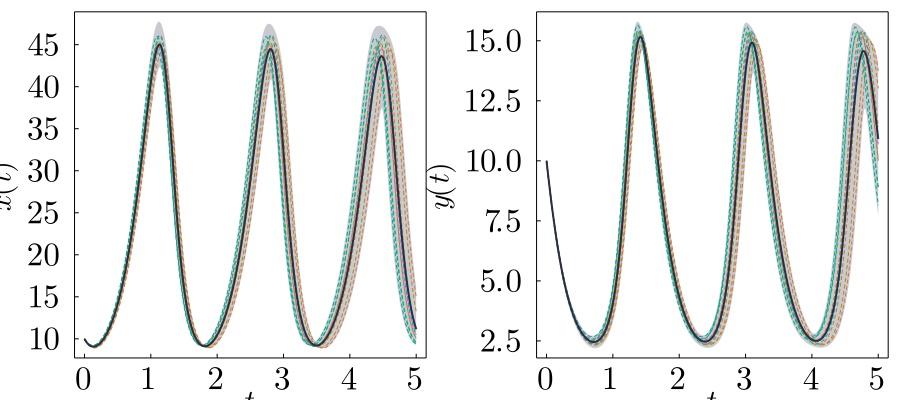

In [55]:
fontsize_tick=22
fontsize_legend=20
fonsize_label = 20
fonsize_titel = 20;

# Plot the interval estimates (for X(t))
p1 = plot(t_,X_lowerquantile; fillrange=X_upperquantile,fillcolor=colorant"#2b2d42", fillalpha=0.25, linealpha=0.0, label=:none,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([0,1,2,3,4,5],[L"0",L"1",L"2",L"3",L"4",L"5"]),
          yticks = ([10,15,20,25,30,35,40,45],[L"10",L"15",L"20",L"25",L"30",L"35",L"40",L"45"]),
          xlabel=L"t",ylabel=L"x(t)", 
          )
# Plot the sampled realizations (evaluation of true ODE) (for X(t))
for (x1sol,x2sol) in deterministic_solutions
    p1 = plot!(t_,x1sol; label=:none, ls=:dash, lw=1)
end
# Plot the mean (for X(t))
p1 = plot!(t_, μₓ; grid=:none, framestyle=:box,label=:none,color=colorant"#2b2d42",lw=2)
# p1 = plot!(t_, getindex.(sol_gal.u, 1), lw=2, lc=:red)

# Plot the interval estimates (for Y(t))
p2 = plot(t_,Y_lowerquantile; fillrange=Y_upperquantile,fillcolor=colorant"#2b2d42", fillalpha=0.25, linealpha=0.0, label=:none,
          legendfontsize=fontsize_legend,yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([0,1,2,3,4,5],[L"0",L"1",L"2",L"3",L"4",L"5"]),
          yticks = ([2.5,5,7.5,10,12.5,15,17.5],[L"2.5",L"5.0", L"7.5",L"10.0",L"12.5",L"15.0",L"17.5"]),
          xlabel=L"t",ylabel=L"y(t)")
# Plot the sampled realizations (evaluation of true ODE) (for X(t))
for (x1sol,x2sol) in deterministic_solutions
    p2 = plot!(t_,x2sol; label=:none, ls=:dash, lw=1)
end
# Plot the mean (for y(t))
p2 = plot!(t_, μy; grid=:none, framestyle=:box,label=:none,color=colorant"#2b2d42",lw=2)
plot(p1,p2; size=(900,400))

The shaded area denotes the PCE-based $95\%$ credible interval showing the distance between the $2.5\%$ and $97.5\%$ quantile at each PCE-based simulated point in time and the thick blue solid line the PCE-based means. The sampled true ODE-solutions fall within the quantile bands. We observe that the uncertainty (illustrated by the width of the quantile bands) increases over time. 
We actually do not get direct increased uncertainty in the up-down direction in time. What happens is that, with the uncertain parameters $\alpha$ and $\delta$ the duration of periodicity changes (wider or shorter). This difference in period length causes the trajectories to diverge with increasing time, which in turn leads to increased uncertainty over time.
The increased uncertainty can also be visualized by the coefficients of the PCE (e.g. $\mu_x \approx \mathcal{G}_0$). We refer to the literature for the analytical construction of statistical moments based on the PCE coefficients.
- [Uncertainty Quantification - (209-210)](https://rsmith.math.ncsu.edu/UQ_TIA/)
- [Uncertainty propagation and sensitivity analysis in mechanical models - (68)](https://ethz.ch/content/dam/ethz/special-interest/baug/ibk/risk-safety-and-uncertainty-dam/publications/reports/HDRSudret.pdf)

In [47]:
# We have to manually identify the indices of the peaks for X(t)
idx_1p = getIndx(μ₁, 25)[1][1] # first peak
idx_2p = getIndx(μ₁, 25)[9][1] # second peak
idx_3p = getIndx(μ₁, 25)[24][1]; # third peak

# get the indices for the valleys of X(t)
idx_1v = getIndx(μ₁, 25, false)[1][1] # first valley
idx_2v = getIndx(μ₁, 25, false)[7][1] # second valley
idx_3v = getIndx(μ₁, 25, false)[21][1]; # third valley

In [48]:
getindex.(sol_gal.u, 1)[idx_1p]

45.023965713717715

# Figure 4.4

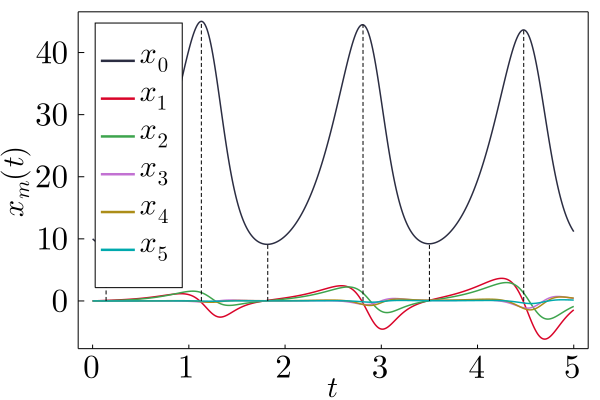

In [54]:
# The first L=15 coefficients are associated to the the population dynamics of the preys
p1 = plot(t_, getindex.(sol_gal.u, 1), framestyle=:box, grid=:none,legendfontsize=fontsize_legend,legend=:topleft,lc=colorant"#2b2d42",
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([0,1,2,3,4,5],[L"0",L"1",L"2",L"3",L"4",L"5"]),
          yticks = ([0,10,20,30,40],[L"0",L"10",L"20",L"30",L"40"]),
          xlabel=L"t",ylabel=L"x_m(t)",lw=1.5,label=L"x_0")
p1 = plot!(t_, getindex.(sol_gal.u, 2),lw=1.5,label=L"x_1",lc=colorant"#d90429")
p1 = plot!(t_, getindex.(sol_gal.u, 3),lw=1.5,label=L"x_2")
p1 = plot!(t_, getindex.(sol_gal.u, 4),lw=1.5,label=L"x_3")
p1 = plot!(t_, getindex.(sol_gal.u, 5),lw=1.5,label=L"x_4")
p1 = plot!(t_, getindex.(sol_gal.u, 6),lw=1.5,label=L"x_5")
p1 = plot!([t_[idx_1p],t_[idx_1p]],[0,getindex.(sol_gal.u, 1)[idx_1p]],label=:none,lw=1,ls=:dash,lc=:black)
p1 = plot!([t_[idx_2p],t_[idx_2p]],[0,getindex.(sol_gal.u, 1)[idx_2p]],label=:none,lw=1,ls=:dash,lc=:black)
p1 = plot!([t_[idx_3p],t_[idx_3p]],[0,getindex.(sol_gal.u, 1)[idx_3p]],label=:none,lw=1,ls=:dash,lc=:black)
p1 = plot!([t_[idx_1v],t_[idx_1v]],[0,getindex.(sol_gal.u, 1)[idx_1v]],label=:none,lw=1,ls=:dash,lc=:black)
p1 = plot!([t_[idx_2v],t_[idx_2v]],[0,getindex.(sol_gal.u, 1)[idx_2v]],label=:none,lw=1,ls=:dash,lc=:black)
p1 = plot!([t_[idx_3v],t_[idx_3v]],[0,getindex.(sol_gal.u, 1)[idx_3v]],label=:none,lw=1,ls=:dash,lc=:black)
plot(p1)

The figure shows the first 6 (out of 15) PCE coefficients for the PCE of the population dynamics of the preys as a function of time. The PCE coefficent for the mean shows oscillary behaviour with decreasing absolute values for lokal minima and maxima. The higher order coefficients grow as a function of time, suggesting that the uncertainty and the higher order moments change in time. It should be noted that the higher order PCE coefficients have small values when the mean value has a local minimum or maximum. The higher order coefficients have the larges absolute value when the gradient of the mean is largest. This indicates that a lot of uncertainty results due to phase-shifts in the oscillation.
A similiar interpretation for a different ODE system can be found in
- [Intrusive Polynomial Chaos Methods
for Forward Uncertainty Propagation pp. 16-17](https://www.osti.gov/servlets/purl/1474821)

The increased uncertainty over time also leads to asymmetric credible intervals, due to non-gaussian densities of $X(T)$ or $Y(t)$ at certain timepoints. We plot a reduced time interval (third peak of the PCE-based mean for $X(t)$ and $Y(t)$) to illustrate the asymmetric and non-gaussian behaviour. Further, we show the density of $X(t)$ and $Y(t)$ at the third peak of the PCE-based mean (blued thick solid line).

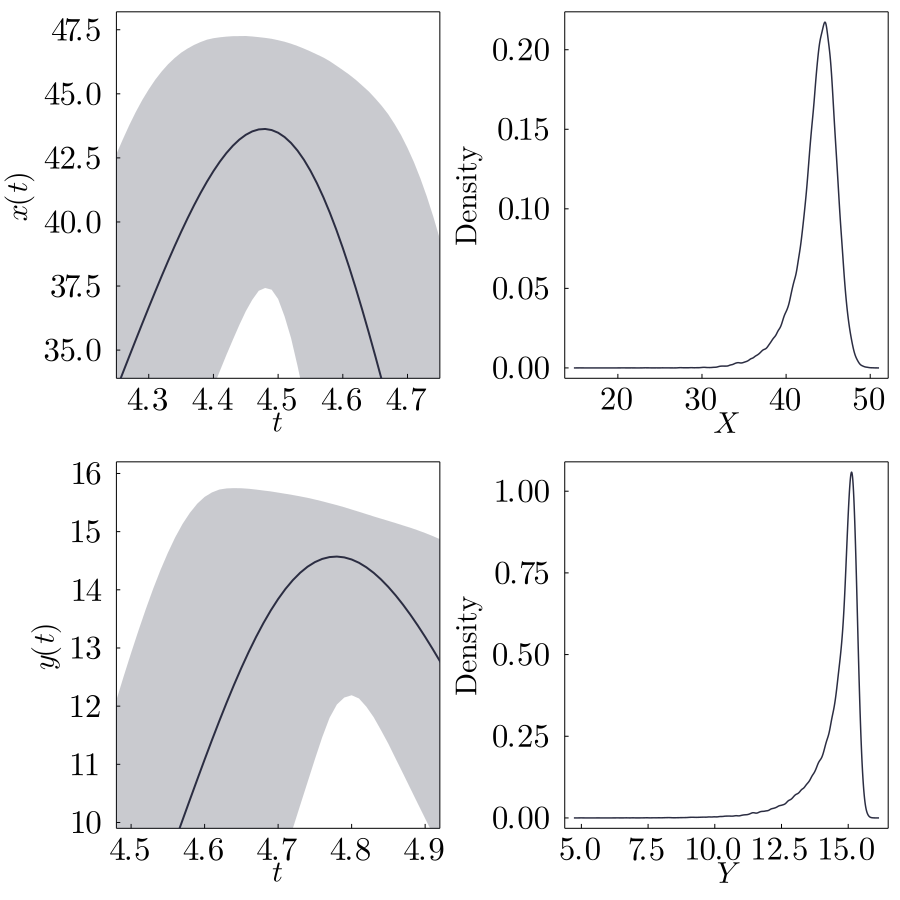

In [56]:
# Plot a reduce time interval to illustrate asymmetric behaviour X(t) third peak
p1 = plot(t_,X_lowerquantile; fillrange=X_upperquantile,fillcolor=colorant"#2b2d42", fillalpha=0.25, linealpha=0.0, label=:none,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([4.3,4.4,4.5,4.6,4.7],[L"4.3",L"4.4",L"4.5",L"4.6",L"4.7"]),
          yticks = ([35,37.5,40,42.5,45,47.5],[L"35.0",L"37.5",L"40.0",L"42.5",L"45.0",L"47.5"]),
          xlabel=L"t",ylabel=L"x(t)", xlim=(4.25,4.75),ylim=(33.9,48.2)
          )
p1 = plot!(t_, μₓ; grid=:none, framestyle=:box,label=:none,color=colorant"#2b2d42",lw=2)

# Plot asymmetric denstity, third peak X(t)
idx_3p = getIndx(μ₁, 25)[24][1] # third peak
X_kde_3p, μₓ_3p, σₓ_3p = getKDEμσ(xycoeffs[1][idx_3p], ξ, mop) # at the third peak
p2 = plot(X_kde_3p.x,X_kde_3p.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"X",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([20,30,40,50],[L"20",L"30",L"40",L"50"]),
          yticks = ([0.00,0.05,0.10,0.15,0.20],[L"0.00",L"0.05", L"0.10",L"0.15",L"0.20"]),
          label=:none,
)

# Plot a reduce time interval to illustrate asymmetric behaviour Y(t) third peak
p3 = plot(t_,Y_lowerquantile; fillrange=Y_upperquantile,fillcolor=colorant"#2b2d42", fillalpha=0.25, linealpha=0.0, label=:none,
          legendfontsize=fontsize_legend,yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([4.5,4.6,4.7,4.8,4.9],[L"4.5",L"4.6",L"4.7",L"4.8",L"4.9"]),
          yticks = ([10,11,12,13,14,15,16],[L"10",L"11", L"12",L"13",L"14",L"15",L"16"]),
          xlabel=L"t",ylabel=L"y(t)",xlim=(4.48,4.92),ylim=(9.9,16.2))
p3 = plot!(t_, μy; grid=:none, framestyle=:box,label=:none,color=colorant"#2b2d42",lw=2)

idy_3p = getIndx(μ₂, 25)[25][1]; # third peak
Y_kde_3p, μy_3p, σy_3p = getKDEμσ(xycoeffs[2][idy_3p], ξ, mop) # at the third peak
# plot asymmetric denstity, third peak Y(t)
p4 = plot(Y_kde_3p.x,Y_kde_3p.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"Y",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = (collect(5:2.5:15),[L"5.0",L"7.5",L"10.0",L"12.5",L"15.0"]),
          yticks = (collect(0:0.25:1),[L"0.00",L"0.25", L"0.50",L"0.75",L"1.00"]),
          label=:none)
plot(p1,p2,p3,p4,size=(900,900))

In the following we further consider three different QoIs $\mathcal{G_{\ell}} = \mathcal{O}_{\ell} \circ G,\; \ell = 1,2,3$. Recall that in our case we estimate the push-forward distribution with the solution resulting from the polynomial chaos expansion (PCE), s.t. $G$ is the PCE operator.
The operators $\mathcal{O}_{\ell},\;\ell = 1,2,3$ stand for the solution of $X(t)$ at the first three timepoints $t$ where the PCE-based mean has its maximal value (peaks).

# Figure 4.5

┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208


	 Statistical moments for X(t) at the peaks
X(t=1.13) 	 μ: 45.03 	 σ: 1.39 	 skewness: 0.0 	 kurtosis: 0.03
X(t=2.81) 	 μ: 44.48 	 σ: 1.64 	 skewness: -0.49 	 kurtosis: 1.02
X(t=4.48) 	 μ: 43.64 	 σ: 2.42 	 skewness: -1.32 	 kurtosis: 3.29


┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208


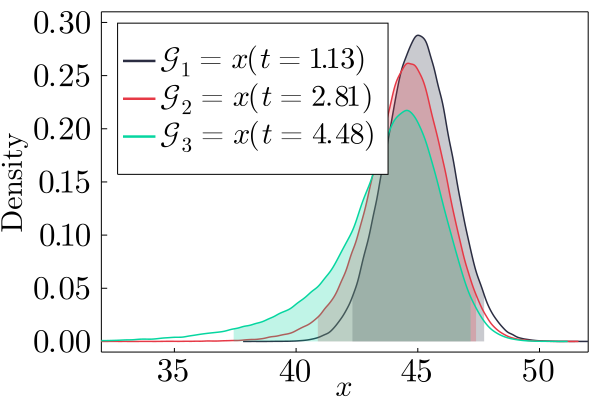

In [65]:
inds = map(i -> (1+(i-1)*L):(i*L), 1:2)
xycoeffs = map( ind -> [u[ind] for u in sol_gal.u], inds);
Nsamples = 200000
ξ = sampleMeasure(Nsamples, mop);

# Distribution for X(t) at the peaks
X_kde_1p, μₓ_1p, σₓ_1p, skewₓ_1p, kurtₓ_1p = getKDEμσ(xycoeffs[1][idx_1p], ξ, mop) # at the first peak
X_kde_2p, μₓ_2p, σₓ_2p, skewₓ_2p, kurtₓ_2p = getKDEμσ(xycoeffs[1][idx_2p], ξ, mop) # at the second peak
X_kde_3p, μₓ_3p, σₓ_3p, skewₓ_3p, kurtₓ_3p = getKDEμσ(xycoeffs[1][idx_3p], ξ, mop) # at the third peak

# Compute associated 95% credible intervals (equal-tailed interval)
X_lower_1p, X_upper_1p = StatsBase.quantile(Xdist[:,idx_1p],0.025), StatsBase.quantile(Xdist[:,idx_1p],0.975)
X_lower_2p, X_upper_2p = StatsBase.quantile(Xdist[:,idx_2p],0.025), StatsBase.quantile(Xdist[:,idx_2p],0.975)
X_lower_3p, X_upper_3p = StatsBase.quantile(Xdist[:,idx_3p],0.025), StatsBase.quantile(Xdist[:,idx_3p],0.975)

# transform univariatekde in 2D array
kde2_X_1p = hcat(X_kde_1p.x,X_kde_1p.density)
kde2_X_2p = hcat(X_kde_2p.x,X_kde_2p.density)
kde2_X_3p = hcat(X_kde_3p.x,X_kde_3p.density) 

# get the array elements within credible interval
cred_X_1p = kde2_X_1p[(X_lower_1p.<=kde2_X_1p[:,1]).&(kde2_X_1p[:,1].<=X_upper_1p),:]
cred_X_2p = kde2_X_2p[(X_lower_2p.<=kde2_X_2p[:,1]).&(kde2_X_2p[:,1].<=X_upper_2p),:]
cred_X_3p = kde2_X_3p[(X_lower_3p.<=kde2_X_3p[:,1]).&(kde2_X_3p[:,1].<=X_upper_3p),:]

println("\t Statistical moments for X(t) at the peaks")
println("X(t=$(t_[idx_1p])) \t μ: $(μₓ_1p) \t σ: $(σₓ_1p) \t skewness: $(skewₓ_1p) \t kurtosis: $(kurtₓ_1p)")
println("X(t=$(t_[idx_2p])) \t μ: $(μₓ_2p) \t σ: $(σₓ_2p) \t skewness: $(skewₓ_2p) \t kurtosis: $(kurtₓ_2p)")
println("X(t=$(t_[idx_3p])) \t μ: $(μₓ_3p) \t σ: $(σₓ_3p) \t skewness: $(skewₓ_3p) \t kurtosis: $(kurtₓ_3p)")

# Plot the distribution for X(t) at the peaks
# first peak
p1 = plot(X_kde_1p.x,X_kde_1p.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",legend=:topleft,
          ylabel=L"\textrm{Density}",xlabel=L"x",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([35,40,45,50],[L"35",L"40",L"45",L"50"]),
          yticks = ([0.00,0.05,0.10,0.15,0.20,0.25,0.30],[L"0.00",L"0.05", L"0.10",L"0.15",L"0.20",L"0.25",L"0.30"]),
          xlim=(32,52), ylim=(-0.01,0.31),label=L"\mathcal{G}_1 = x(t=%$(t_[idx_1p]))"
)
p1 = plot!(cred_X_1p[:,1], zeros(length(cred_X_1p[:,1])),fillrange=cred_X_1p[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,label=:none)

# second peak
p1 = plot!(X_kde_2p.x,X_kde_2p.density,lw=1.5,lc=colorant"#e63946",label=L"\mathcal{G}_2 = x(t=%$(t_[idx_2p]))")
p1 = plot!(cred_X_2p[:,1], zeros(length(cred_X_2p[:,1])),fillrange=cred_X_2p[:,2],fillcolor=colorant"#e63946",
     fillalpha=0.25,linealpha=0.0,label=:none)

# third peak
p1 = plot!(X_kde_3p.x,X_kde_3p.density,lw=1.5, lc=colorant"#06d6a0",label=L"\mathcal{G}_3 = x(t=%$(t_[idx_3p]))")
p1 = plot!(cred_X_3p[:,1], zeros(length(cred_X_3p[:,1])),fillrange=cred_X_3p[:,2],fillcolor=colorant"#06d6a0",
     fillalpha=0.25,linealpha=0.0,label=:none)
plot(p1)

In our case, the increasing asymmetric densities of the PCE-based mean, is a result of the divergence of the trajectories with increasing time due to the difference in period lengths (the difference in the period duration results of the uncertain parameters $\alpha$ and $\delta$). 

<!-- Note that the solution itself is a random variable.
In the following we consider different QoIs $\mathcal{G_{\ell}} = \mathcal{O}_{\ell} \circ G,\; \ell = 1,\dots,12$. Recall that in our case we estimate the push-forward distribution with the solution resulting from the polynomial chaos expansion (PCE), s.t. $G$ is the PCE operator.
The operators $\mathcal{O}_{\ell},\;\ell = 1,2,3$ stand for the solution of $X(t)$ at the first three timepoints $t$ where the PCE-based mean has its maximal values (peaks), while  $\mathcal{O}_{\ell},\;\ell = 4,5,6$ denotes solution of $X(t)$ for the timepoints where the PCE-based means has the minimal values (valleys). Similary, the operators $\mathcal{O}_{\ell},\;\ell = 7,8,9$ stand for the solution of $X(t)$ at the first three timepoints $t$ where the PCE-based mean has its maximal values (peaks), whereas $\mathcal{O}_{\ell},\;\ell = 10,11,12$ denotes solution of $X(t)$ for the timepoints where the PCE-based means has the minimal values (valleys).
 -->
 
To study for example the push-forward uncertainty in the maximum and minimum values of the dynamical system, we consider different QoIs $\mathcal{G_{\ell}} = \mathcal{O}_{\ell} \circ G,\; \ell = 1,\dots,4$. Recall that in our case we estimate the push-forward distribution with the solution resulting from the polynomial chaos expansion (PCE), s.t. $G$ is the PCE operator.
The operator $\mathcal{O}_1$ stands for the maximum value (peak) of a realization of $X(t)$, while $\mathcal{O}_2$ denotes the minimal value (valley). 
The operator $\mathcal{O}_3$ stands for the maximum value (peak) of a realization of $Y(t)$, whereas $\mathcal{O}_4$ denotes the minimal value (valley). It should be noted, that the maximum and minimum values (values at the peaks and valleys) of a period in a specific realization remain constant.

In [66]:
# intit arrays
𝒢₁_dist, 𝒢₂_dist, 𝒢₃_dist, 𝒢₄_dist = zeros(Nsamples), zeros(Nsamples), zeros(Nsamples), zeros(Nsamples)

# Get the realizations of the QoIs
prog = Progress(Nsamples,1)
for i in 1:Nsamples
    # get the maximum value for each realization 
    𝒢₁_dist[i] = Xdist[i, getIndx(Xdist[i,1:200], 1,true)[1][1]::Int] # for X(t)
    𝒢₃_dist[i] = Ydist[i, getIndx(Ydist[i,1:200], 1,true)[1][1]::Int] # for Y(t)
    # get the minimum value for each realization 
    𝒢₂_dist[i] = Xdist[i, getIndx(Xdist[i,1:100], 1,false)[1][1]::Int] # for X(t)
    𝒢₄_dist[i] = Ydist[i, getIndx(Ydist[i,1:130], 1,false)[1][1]::Int] # for Y(t)
    next!(prog)
end

Progress:  31%|█████████████                            |  ETA: 0:00:05

LoadError: [91mBoundsError: attempt to access 100000×501 Array{Float64,2} at index [100001, 1:200][39m

In [22]:
# Get the statistics: Kernel density estimation, mean, standard deviation, skewness, kurtosis
𝒢₁_kde, 𝒢₁_μ, 𝒢₁_σ, 𝒢₁_skew, 𝒢₁_kurt = getStatistics(𝒢₁_dist)
𝒢₂_kde, 𝒢₂_μ, 𝒢₂_σ, 𝒢₂_skew, 𝒢₂_kurt = getStatistics(𝒢₂_dist)
𝒢₃_kde, 𝒢₃_μ, 𝒢₃_σ, 𝒢₃_skew, 𝒢₃_kurt = getStatistics(𝒢₃_dist)
𝒢₄_kde, 𝒢₄_μ, 𝒢₄_σ, 𝒢₄_skew, 𝒢₄_kurt = getStatistics(𝒢₄_dist);

# Get the elements within the credible interval
𝒢₁_cred = getCredElements(𝒢₁_kde,𝒢₁_dist)
𝒢₂_cred = getCredElements(𝒢₂_kde,𝒢₂_dist)
𝒢₃_cred = getCredElements(𝒢₃_kde,𝒢₃_dist)
𝒢₄_cred = getCredElements(𝒢₄_kde,𝒢₄_dist);

		Statistics for the QoIs
	 μ 	 σ 	 skewness 	 kurtosis
𝒢₁ 	 45.21 	 1.37 	 0.02 		 0.01
𝒢₂ 	 9.07 	 0.09 	 -0.17 		 0.03
𝒢₃ 	 15.26 	 0.29 	 0.04 		 0.0
𝒢₄ 	 2.45 	 0.13 	 0.09 		 -0.0


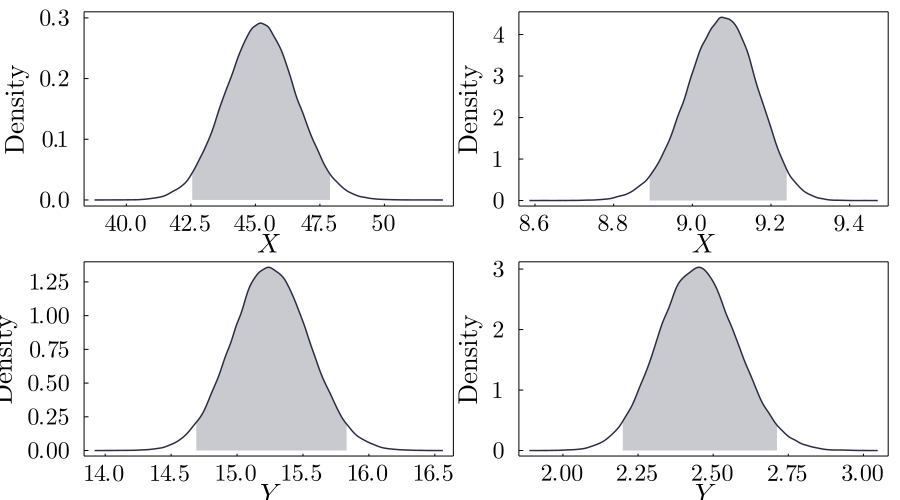

In [23]:
p1 = plot(𝒢₁_kde.x,𝒢₁_kde.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"X",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([40,42.5,45,47.5,50],[L"40.0",L"42.5",L"45.0",L"47.5",L"50"]),
          yticks = ([0.0,0.1,0.2,0.3],[L"0.0",L"0.1", L"0.2",L"0.3"]),label=:none,ylim=(-0.01,0.31)
)
p1 = plot!(𝒢₁_cred[:,1],  zeros(length(𝒢₁_cred[:,1])),fillrange=𝒢₁_cred[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

p2 = plot(𝒢₂_kde.x,𝒢₂_kde.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"X",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([8.6,8.8,9.0,9.2,9.4],[L"8.6",L"8.8",L"9.0",L"9.2",L"9.4"]),
          yticks = ([0,1,2,3,4],[L"0",L"1", L"2",L"3",L"4"]),
          label=:none
)
p2 = plot!(𝒢₂_cred[:,1],  zeros(length(𝒢₂_cred[:,1])),fillrange=𝒢₂_cred[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

p3 = plot(𝒢₃_kde.x,𝒢₃_kde.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"Y",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([14.0,14.5,15.0,15.5,16,16.5],[L"14.0",L"14.5",L"15.0",L"15.5",L"16.0",L"16.5"]),
          yticks = ([0,0.25,0.5,0.75,1,1.25],[L"0.00",L"0.25", L"0.50",L"0.75",L"1.00",L"1.25"]),
          label=:none
)
p3 = plot!(𝒢₃_cred[:,1],  zeros(length(𝒢₃_cred[:,1])),fillrange=𝒢₃_cred[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

p4 = plot(𝒢₄_kde.x,𝒢₄_kde.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"Y",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([2.00,2.25,2.50,2.75,3.00],[L"2.00",L"2.25",L"2.50",L"2.75",L"3.00"]),
          yticks = ([0,1,2,3],[L"0",L"1", L"2",L"3"]),
          label=:none)
p4 = plot!(𝒢₄_cred[:,1],  zeros(length(𝒢₄_cred[:,1])),fillrange=𝒢₄_cred[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

println("\t\tStatistics for the QoIs")
println("\t μ \t σ \t skewness \t kurtosis")
println("𝒢₁ \t $(𝒢₁_μ) \t $(𝒢₁_σ) \t $(𝒢₁_skew) \t\t $(𝒢₁_kurt)")
println("𝒢₂ \t $(𝒢₂_μ) \t $(𝒢₂_σ) \t $(𝒢₂_skew) \t\t $(𝒢₂_kurt)")
println("𝒢₃ \t $(𝒢₃_μ) \t $(𝒢₃_σ) \t $(𝒢₃_skew) \t\t $(𝒢₃_kurt)")
println("𝒢₄ \t $(𝒢₄_μ) \t $(𝒢₄_σ) \t $(𝒢₄_skew) \t\t $(𝒢₄_kurt)")

plot(p1,p2,p3,p4,size=(900,500))

The figures illustrate the push-forward distribution with the $95\%$ credible interval (shaded area) (using equal-tailed interval method). 

# !!! Other Material not relevant for the Example

In [24]:
# We have to manually identify the indices of the peaks and valleys for X(t)
idx_1p = getIndx(μ₁, 25)[1][1] # first peak
idx_2p = getIndx(μ₁, 25)[9][1] # second peak
idx_3p = getIndx(μ₁, 25)[24][1]; # third peak

idx_1v = getIndx(μ₁, 25, false)[1][1] # first valley
idx_2v = getIndx(μ₁, 25, false)[7][1] # second valley
idx_3v = getIndx(μ₁, 25, false)[21][1]; # third valley

# Identify the indices of the peaks and valleys for Y(t) 1, 9, 25, 1, 8, 24
idy_1p = getIndx(μ₂, 25)[1][1] # first peak
idy_2p = getIndx(μ₂, 25)[9][1] # second peak
idy_3p = getIndx(μ₂, 25)[25][1]; # third peak

idy_1v = getIndx(μ₂, 25, false)[1][1] # first valley
idy_2v = getIndx(μ₂, 25, false)[8][1] # second valley
idy_3v = getIndx(μ₂, 25, false)[24][1]; # third valley

┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208


	 Statistical moments for X(t) at the peaks
X(t=1.13) 	 μ: 45.02 	 σ: 1.39 	 skewness: -0.0 	 kurtosis: 0.02
X(t=2.81) 	 μ: 44.48 	 σ: 1.64 	 skewness: -0.5 	 kurtosis: 1.03
X(t=4.48) 	 μ: 43.65 	 σ: 2.41 	 skewness: -1.32 	 kurtosis: 3.3

	 Statistical moments for for X(t) at the valleys
X(t=0.14) 	 μ: 9.08 	 σ: 0.09 	 skewness: 0.03 	 kurtosis: -0.01
X(t=1.82) 	 μ: 9.12 	 σ: 0.12 	 skewness: 1.77 	 kurtosis: 4.44
X(t=3.5) 	 μ: 9.2 	 σ: 0.21 	 skewness: 2.56 	 kurtosis: 9.85

┌ Warning: ignoring keyword method; sampling from Distributions.jl instead
└ @ PolyChaos C:\Users\valen\.julia\packages\PolyChaos\T7Zic\src\polynomial_chaos.jl:208





	 Statistical moments for for Y(t) at the peaks
Y(t=1.42) 	 μ: 15.16 	 σ: 0.29 	 skewness: -1.09 	 kurtosis: 2.69
Y(t=3.1) 	 μ: 14.92 	 σ: 0.51 	 skewness: -2.38 	 kurtosis: 9.5
Y(t=4.78) 	 μ: 14.58 	 σ: 0.91 	 skewness: -2.36 	 kurtosis: 8.12

	 Statistical moments for for Y(t) at the valleys
Y(t=0.71) 	 μ: 2.45 	 σ: 0.13 	 skewness: 0.14 	 kurtosis: 0.02
Y(t=2.39) 	 μ: 2.47 	 σ: 0.14 	 skewness: 0.3 	 kurtosis: 0.31
Y(t=4.06) 	 μ: 2.5 	 σ: 0.15 	 skewness: 0.74 	 kurtosis: 2.16


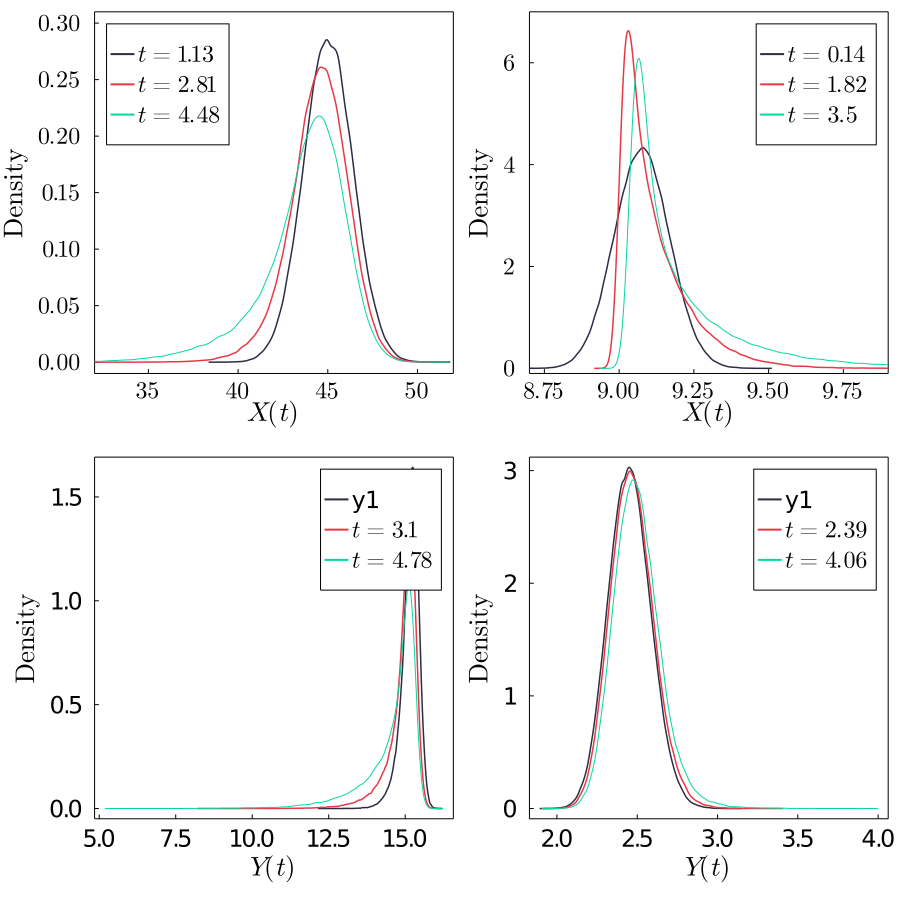

In [27]:
inds = map(i -> (1+(i-1)*L):(i*L), 1:2)
xycoeffs = map( ind -> [u[ind] for u in sol_gal.u], inds);
Nsamples = 200000
ξ = sampleMeasure(Nsamples, mop);

# Distribution for X(t) at the peaks and valleys
X_kde_1p, μₓ_1p, σₓ_1p, skewₓ_1p, kurtₓ_1p = getKDEμσ(xycoeffs[1][idx_1p], ξ, mop) # at the first peak
X_kde_2p, μₓ_2p, σₓ_2p, skewₓ_2p, kurtₓ_2p = getKDEμσ(xycoeffs[1][idx_2p], ξ, mop) # at the second peak
X_kde_3p, μₓ_3p, σₓ_3p, skewₓ_3p, kurtₓ_3p = getKDEμσ(xycoeffs[1][idx_3p], ξ, mop) # at the third peak
X_kde_1v, μₓ_1v, σₓ_1v, skewₓ_1v, kurtₓ_1v = getKDEμσ(xycoeffs[1][idx_1v], ξ, mop) # at the first valley
X_kde_2v, μₓ_2v, σₓ_2v, skewₓ_2v, kurtₓ_2v = getKDEμσ(xycoeffs[1][idx_2v], ξ, mop) # at the second valley
X_kde_3v, μₓ_3v, σₓ_3v, skewₓ_3v, kurtₓ_3v = getKDEμσ(xycoeffs[1][idx_3v], ξ, mop) # at the third valley

println("\t Statistical moments for X(t) at the peaks")
println("X(t=$(t_[idx_1p])) \t μ: $(μₓ_1p) \t σ: $(σₓ_1p) \t skewness: $(skewₓ_1p) \t kurtosis: $(kurtₓ_1p)")
println("X(t=$(t_[idx_2p])) \t μ: $(μₓ_2p) \t σ: $(σₓ_2p) \t skewness: $(skewₓ_2p) \t kurtosis: $(kurtₓ_2p)")
println("X(t=$(t_[idx_3p])) \t μ: $(μₓ_3p) \t σ: $(σₓ_3p) \t skewness: $(skewₓ_3p) \t kurtosis: $(kurtₓ_3p)")
println("\n\t Statistical moments for for X(t) at the valleys")
println("X(t=$(t_[idx_1v])) \t μ: $(μₓ_1v) \t σ: $(σₓ_1v) \t skewness: $(skewₓ_1v) \t kurtosis: $(kurtₓ_1v)")
println("X(t=$(t_[idx_2v])) \t μ: $(μₓ_2v) \t σ: $(σₓ_2v) \t skewness: $(skewₓ_2v) \t kurtosis: $(kurtₓ_2v)")
println("X(t=$(t_[idx_3v])) \t μ: $(μₓ_3v) \t σ: $(σₓ_3v) \t skewness: $(skewₓ_3v) \t kurtosis: $(kurtₓ_3v)")

# Distribution for Y(t) at the peaks and valleys
Y_kde_1p, μy_1p, σy_1p, skewy_1p, kurty_1p = getKDEμσ(xycoeffs[2][idy_1p], ξ, mop) # at the first peak
Y_kde_2p, μy_2p, σy_2p, skewy_2p, kurty_2p = getKDEμσ(xycoeffs[2][idy_2p], ξ, mop) # at the second peak
Y_kde_3p, μy_3p, σy_3p, skewy_3p, kurty_3p = getKDEμσ(xycoeffs[2][idy_3p], ξ, mop) # at the third peak
Y_kde_1v, μy_1v, σy_1v, skewy_1v, kurty_1v = getKDEμσ(xycoeffs[2][idy_1v], ξ, mop) # at the first valley
Y_kde_2v, μy_2v, σy_2v, skewy_2v, kurty_2v = getKDEμσ(xycoeffs[2][idy_2v], ξ, mop) # at the second valley
Y_kde_3v, μy_3v, σy_3v, skewy_3v, kurty_3v = getKDEμσ(xycoeffs[2][idy_3v], ξ, mop) # at the third valley

println("\n\n\t Statistical moments for for Y(t) at the peaks")
println("Y(t=$(t_[idy_1p])) \t μ: $(μy_1p) \t σ: $(σy_1p) \t skewness: $(skewy_1p) \t kurtosis: $(kurty_1p)")
println("Y(t=$(t_[idy_2p])) \t μ: $(μy_2p) \t σ: $(σy_2p) \t skewness: $(skewy_2p) \t kurtosis: $(kurty_2p)")
println("Y(t=$(t_[idy_3p])) \t μ: $(μy_3p) \t σ: $(σy_3p) \t skewness: $(skewy_3p) \t kurtosis: $(kurty_3p)")
println("\n\t Statistical moments for for Y(t) at the valleys")
println("Y(t=$(t_[idy_1v])) \t μ: $(μy_1v) \t σ: $(σy_1v) \t skewness: $(skewy_1v) \t kurtosis: $(kurty_1v)")
println("Y(t=$(t_[idy_2v])) \t μ: $(μy_2v) \t σ: $(σy_2v) \t skewness: $(skewy_2v) \t kurtosis: $(kurty_2v)")
println("Y(t=$(t_[idy_3v])) \t μ: $(μy_3v) \t σ: $(σy_3v) \t skewness: $(skewy_3v) \t kurtosis: $(kurty_3v)")

# Plot the distribution for X(t) at the peaks
p1 = plot(X_kde_1p.x,X_kde_1p.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",legend=:topleft,
          ylabel=L"\textrm{Density}",xlabel=L"X(t)",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([35,40,45,50],[L"35",L"40",L"45",L"50"]),
          yticks = ([0.00,0.05,0.10,0.15,0.20,0.25,0.30],[L"0.00",L"0.05", L"0.10",L"0.15",L"0.20",L"0.25",L"0.30"]),
          xlim=(32,52), ylim=(-0.01,0.31),label=L"t = %$(t_[idx_1p])"
)
p1 = plot!(X_kde_2p.x,X_kde_2p.density,lw=1.5,lc=colorant"#e63946",label=L"t = %$(t_[idx_2p])")
p1 = plot!(X_kde_3p.x,X_kde_3p.density,l2=1.5, lc=colorant"#06d6a0",label=L"t = %$(t_[idx_3p])")

# Plot the distribution for X(t) at the valleys
p2 = plot(X_kde_1v.x,X_kde_1v.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"X(t)",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xticks = ([8.75,9.00,9.25,9.50,9.75],[L"8.75",L"9.00",L"9.25",L"9.50",L"9.75"]),
          yticks = ([0,2,4,6],[L"0",L"2", L"4",L"6"]),
          xlim=(8.7,9.9), ylim=(-0.1,7),label=L"t = %$(t_[idx_1v])"
)
p2 = plot!(X_kde_2v.x,X_kde_2v.density,lw=1.5,lc=colorant"#e63946",label=L"t = %$(t_[idx_2v])")
p2 = plot!(X_kde_3v.x,X_kde_3v.density,l2=1.5, lc=colorant"#06d6a0",label=L"t = %$(t_[idx_3v])")


# Plot the distribution for Y(t) at the peaks
p3 = plot(Y_kde_1p.x,Y_kde_1p.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"Y(t)",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
#           xticks = ([35,40,45,50],[L"35",L"40",L"45",L"50"]),
#           yticks = ([0.00,0.05,0.10,0.15,0.20,0.25,0.30],[L"0.00",L"0.05", L"0.10",L"0.15",L"0.20",L"0.25",L"0.30"]),
#           xlim=(32,52), ylim=(-0.01,0.31),label=L"t = %$(t_[idy_1p])"
)
p3 = plot!(Y_kde_2p.x,Y_kde_2p.density,lw=1.5,lc=colorant"#e63946",label=L"t = %$(t_[idy_2p])")
p3 = plot!(Y_kde_3p.x,Y_kde_3p.density,l2=1.5, lc=colorant"#06d6a0",label=L"t = %$(t_[idy_3p])")

# Plot the distribution for X(t) at the valleys
p4 = plot(Y_kde_1v.x,Y_kde_1v.density,framestyle=:box, grid=:none, lw=1.5,lc=colorant"#2b2d42",
          ylabel=L"\textrm{Density}",xlabel=L"Y(t)",legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
#           xticks = ([8.75,9.00,9.25,9.50,9.75],[L"8.75",L"9.00",L"9.25",L"9.50",L"9.75"]),
#           yticks = ([0,2,4,6],[L"0",L"2", L"4",L"6"]),
#           xlim=(8.7,9.9), ylim=(-0.1,7),label=L"t = %$(t_[idy_1v])"
)
p4 = plot!(Y_kde_2v.x,Y_kde_2v.density,lw=1.5,lc=colorant"#e63946",label=L"t = %$(t_[idy_2v])")
p4 = plot!(Y_kde_3v.x,Y_kde_3v.density,l2=1.5, lc=colorant"#06d6a0",label=L"t = %$(t_[idy_3v])")

plot(p1, p2, p3 ,p4, size=(900,900))